In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:

def F_H(H, params, model):     
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        FH = H**2 - beta * H**(2*r) * L_bar**(2*(r-1)) * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        FH = H**2 - beta * H**2                        * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    return FH


def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
   
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s)) * (L_bar*H)**(2*(r-1)) * (-r + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1))     * (p  + q * lamb * (L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s))                        * (-1 + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1)) * (p  + q * lamb * (L*H)**(2*q))

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, r, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, r, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, r, s], model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, r, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, r, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [3]:
def chi2_without_cov(teo, data, errors_cuad):
    '''
    Calculate chi square assuming no correlation.

    teo (array): Theoretical prediction of the model.
    data (array): Observational data to compare with the model.
    errors_cuad (array): The square of the errors of the data.

    '''

    chi2 = np.sum((data-teo)**2/errors_cuad)
    return chi2

def params_to_chi2(theta, model, dataset_CC=None,dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5)):

    chi2_SN = 0
    [Mabs, L_bar, b, H_0, r, s] = theta
    physical_params = [L_bar, b, H_0, r, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    Hs_interp = interp1d(zs_model, Hs_model)

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_CC != None:
        z_data, H_data, dH = dataset_CC #Import the data
        H_teo = Hs_interp(z_data)
        chi2_CC = chi2_without_cov(H_teo, H_data, dH**2)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN + chi2_CC

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [4]:
#Fix params
omega_r = 2.47e-5 
L_bar = 0.90
#M_abs = -19.3
#M_abs = -19.321 #GILA

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

z = np.linspace(0, 1000, int(10e3))
aou_threshold = 12.7

dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0])-2

# GILA model analysis

In [5]:
#GILA MODEL
#r_min = 3
#s_min = 1

#r = 3; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(0.2,8,25)

#r = 8; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(1,80,25)

#r = 3; s = 2 #It works, not with AoU
#H0_values = np.linspace(64,74,25)[::-1] 
#beta_values = np.linspace(0.8,4,25)

#r = 3; s = 4 #It works, not with AoU
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,8,25)

r = 3; s = 5 #It worked, even with AoU!
H0_values = np.linspace(67,76,50)[::-1] 
beta_values = np.linspace(0.1,7,50)
Mabs_values = np.linspace(-19.5,-19.1,10)

#r = 3; s = 6 #It worked, even with AoU!
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,4,25)


print(H0_values, beta_values, Mabs_values)

matrix_gila_chi2_1 = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
matrix_gila_chi2_2 = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
matrix_gila_chi2_3 = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))
matrix_gila_chi2_4 = np.zeros((len(H0_values), len(beta_values),len(Mabs_values)))


for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
            for k, Mabs_val in enumerate(Mabs_values):
                physical_params = [L_bar, beta_val, H0_val, r, s]
                try :        
                    z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                                    initial_z=z[0], final_z=z[-1])
                except Exception as e:
                    # If integration fails
                    matrix_gila_chi2_1[i, j, k] = -np.inf #np.nan
                    matrix_gila_chi2_2[i, j, k] = -np.inf #np.nan
                    matrix_gila_chi2_3[i, j, k] = -np.inf #np.nan
                    matrix_gila_chi2_4[i, j,] = -np.inf #np.nan
                    continue

                theta = [Mabs_val, L_bar, beta_val, H0_val, r, s]
                chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, dataset_CC=ds_CC, model='GILA')#/dof
                if chi2 > dof + np.sqrt(2*dof):
                    matrix_gila_chi2_1[i, j, k] =  chi2 / dof
                    matrix_gila_chi2_2[i, j, k] =  -np.inf #np.nan
                    matrix_gila_chi2_3[i, j, k] =  chi2 / dof
                    matrix_gila_chi2_4[i, j, k] =  -np.inf #np.nan
                else:
                    matrix_gila_chi2_1[i, j, k] = chi2 / dof #0
                    matrix_gila_chi2_2[i, j, k] = chi2 / dof #0
                    matrix_gila_chi2_3[i, j, k] = chi2 / dof #0
                    matrix_gila_chi2_4[i, j, k] = chi2 / dof #0

                aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
                if aou_gila < aou_threshold:
                    matrix_gila_chi2_3[i, j, k] = -np.inf #np.nan
                    matrix_gila_chi2_4[i, j, k] = -np.inf #np.nan

np.save(os.path.join(path_data, 'matrix_gila_chi2_1.npy'), matrix_gila_chi2_1)
np.save(os.path.join(path_data, 'matrix_gila_chi2_2.npy'), matrix_gila_chi2_2)
np.save(os.path.join(path_data, 'matrix_gila_chi2_3.npy'), matrix_gila_chi2_3)
np.save(os.path.join(path_data, 'matrix_gila_chi2_4.npy'), matrix_gila_chi2_4)

[76.   73.75 71.5  69.25 67.  ] [0.1   1.825 3.55  5.275 7.   ] [-19.5 -19.4 -19.3 -19.2 -19.1]


[[[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.         2.57862941 0.         0.        ]
  [0.         0.         2.76074273 0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.         2.77789556 0.         0.        ]
  [0.         2.77654443 0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         2.59611817 0.         0.         0. 

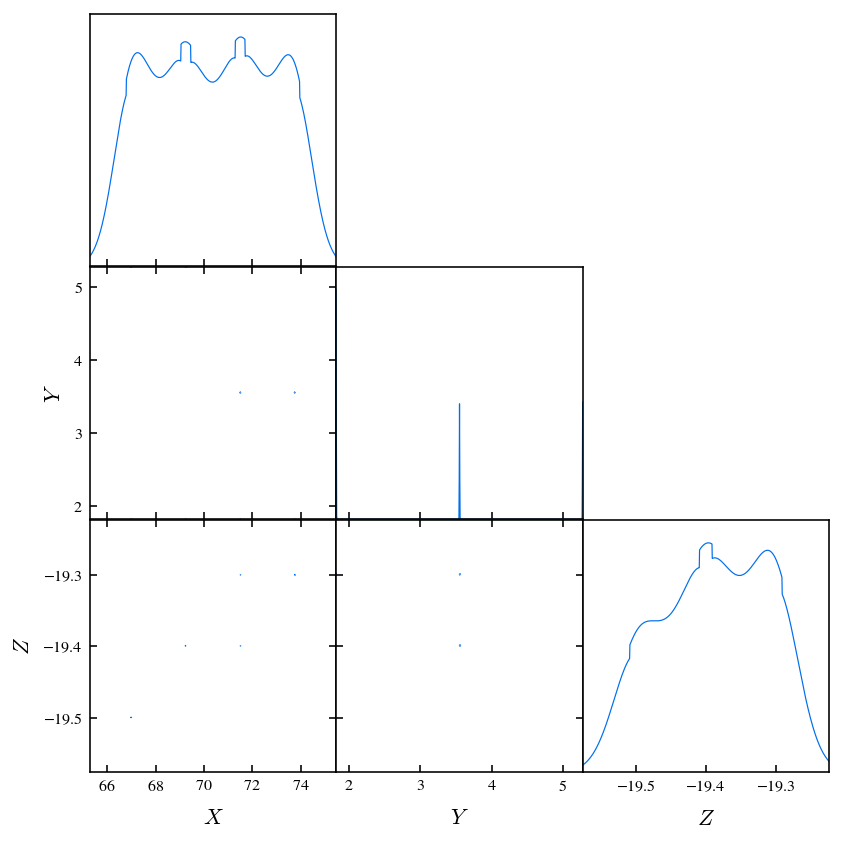

In [7]:
import numpy as np
import getdist
import getdist.plots as gdplt
import matplotlib.pyplot as plt

# Example: Define a 3D probability grid (replace with your actual posterior)
#Nx, Ny, Nz = 50, 50, 50  # Grid size
#x_vals = np.linspace(67,76,50)[::-1]  #np.linspace(-3, 3, Nx)
#y_vals = np.linspace(0.1,7,50) #np.linspace(-3, 3, Ny)
#z_vals = np.linspace(-3, 3, Nz)

# Example posterior: A 3D Gaussian distribution
#X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')
#p3d = np.exp(-0.5 * (X**2 + Y**2 + Z**2))  # Gaussian posterior

x_vals = H0_values 
y_vals = beta_values 
z_vals = Mabs_values

matrix_gila_chi2_1 = np.load(os.path.join(path_data, 'matrix_gila_chi2_1.npy'))
matrix_gila_chi2_2 = np.load(os.path.join(path_data, 'matrix_gila_chi2_2.npy'))
matrix_gila_chi2_3 = np.load(os.path.join(path_data, 'matrix_gila_chi2_3.npy'))
matrix_gila_chi2_4 = np.load(os.path.join(path_data, 'matrix_gila_chi2_4.npy'))


p3d = np.exp(matrix_gila_chi2_4)
print(p3d)

# Normalize the distribution
p3d /= np.sum(p3d)
print(p3d.shape)
# Convert 3D posterior into samples
flattened_probs = p3d.flatten()
grid_points = np.array(np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')).reshape(3, -1).T

# Sample points from the distribution
num_samples = 10000  # Number of samples you want
sample_indices = np.random.choice(len(flattened_probs), size=num_samples, p=flattened_probs)
samples = grid_points[sample_indices]

# Convert to GetDist format
gd_samples = getdist.mcsamples.MCSamples(samples=samples, names=['x', 'y', 'z'], labels=['X', 'Y', 'Z'])

# Plot using GetDist
g = gdplt.get_subplot_plotter()
g.triangle_plot([gd_samples], filled=True)
plt.show()





